<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/DistributedTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- Understand how distributed training works and improve the efficiency

### Why do we need distributed training ?
- Models are getting larger. Training takes a long time.
  - NVIDIA A 100 provides 312TFLOPS at FP16 and 19.5 TFLOPS at FP32
- Developer / researcher time is more valuable than hardware.
  - If training takes 10 GPU days, TotalWorkDone = WorkDonePerSec * 10 * 86400
  - If we have 1024 GPUs, TimeTakenInMinutes = WorkDonePerSec * 10 * 86400 / (1024 * 60) = 14


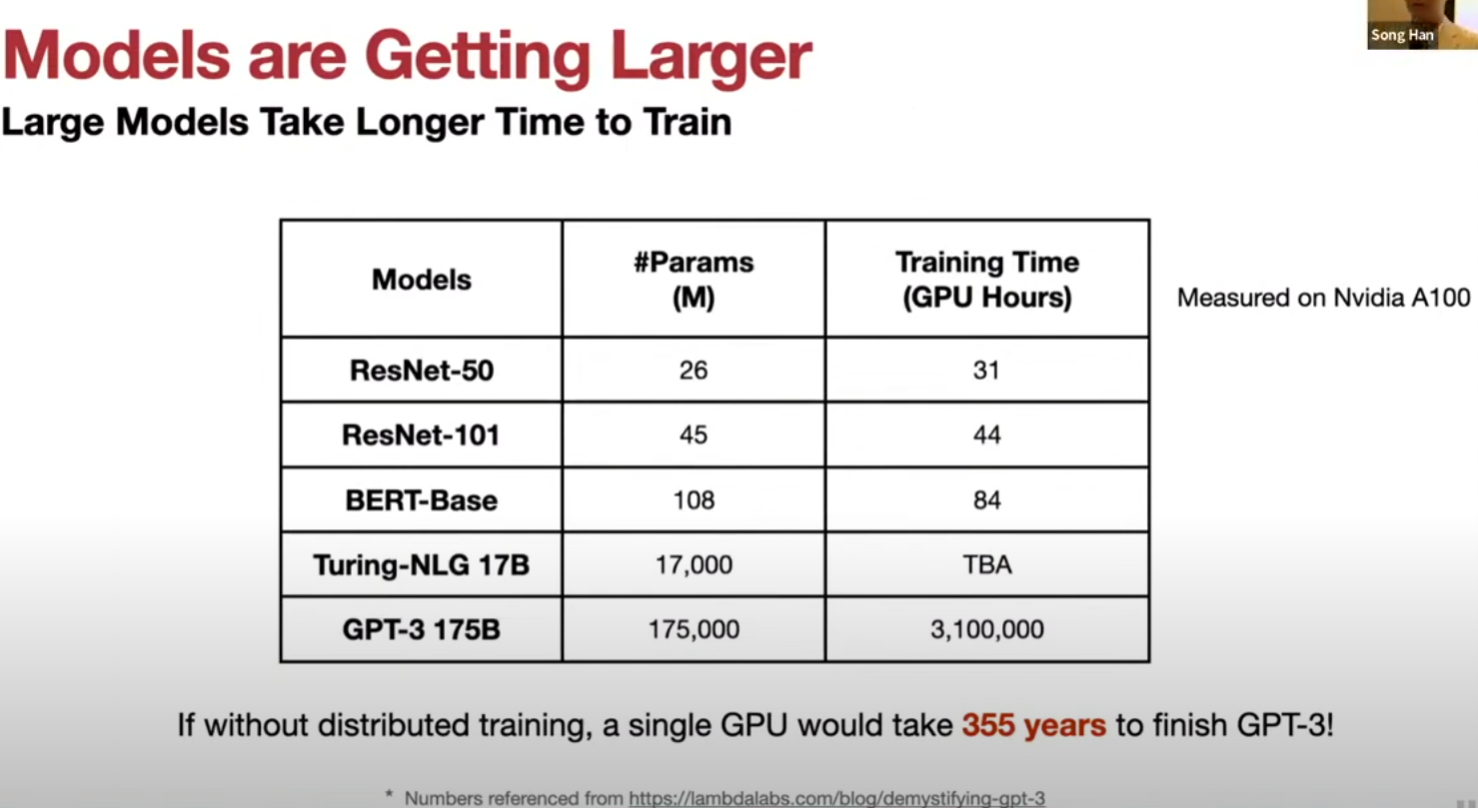

#### Example
- TSM video model needs to be trained on 660 hours of videos.
- With 6 GPUs, it takes ~50h, with 768 GPUs, its down to 28 minutes and with 1500 GPUs, its down to 15 minutes.

### Data parallelism

- In data parallelism, data is sent to different GPUs.
- Same model is used across devices
- Parameter server controls the whole training process. Receieves gradients from workers and send back aggregated results
  1. Replicate and pull
    - Replicates copy of model onto every worker CPU
    - Broadcast communication primitive is used. Identical weight is sent to all worker nodes. Bandwidth cost is O(N) on parameter server.
  5. Update model weights
    - Gradients are aggregated, weights are updated.
    - Reduce communication primitive is used to average gradients from all workers. Bandwidth cost is O(N) on parameter server.
- Workers compute gradients using spllited dataset and send to parameter server.
  2. Randomly spread dataset over GPUs
  3. Compute gradient
    - Each GPU computes gradients independently
  4. Push and sum
    - Each GPU does a push & Sum to push gradients to server.

- Compared to a single node training, distributed training has 2 extra steps for synchronization.  To replicate model from central server and push gradients back to central server. Gradient update step is performed at parameter server after aggregation.






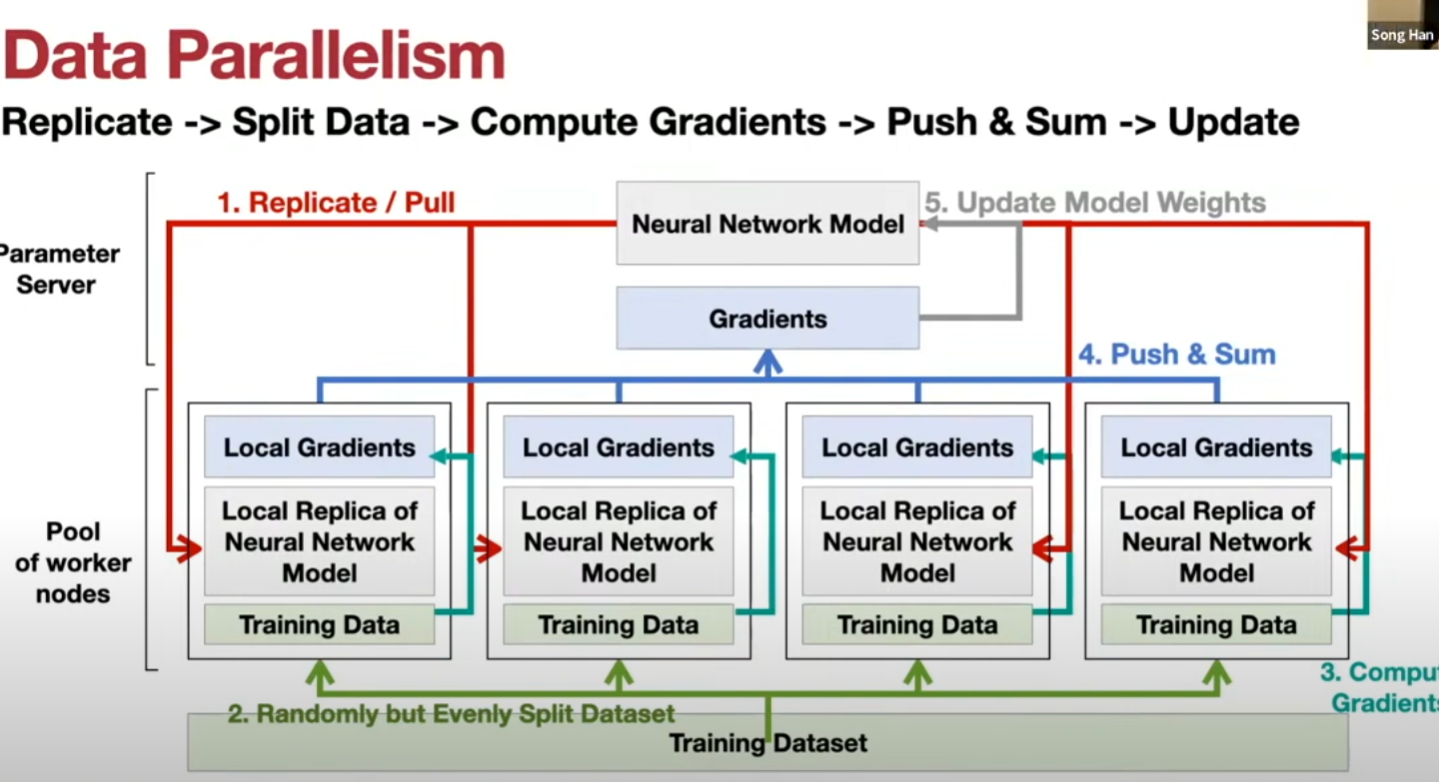

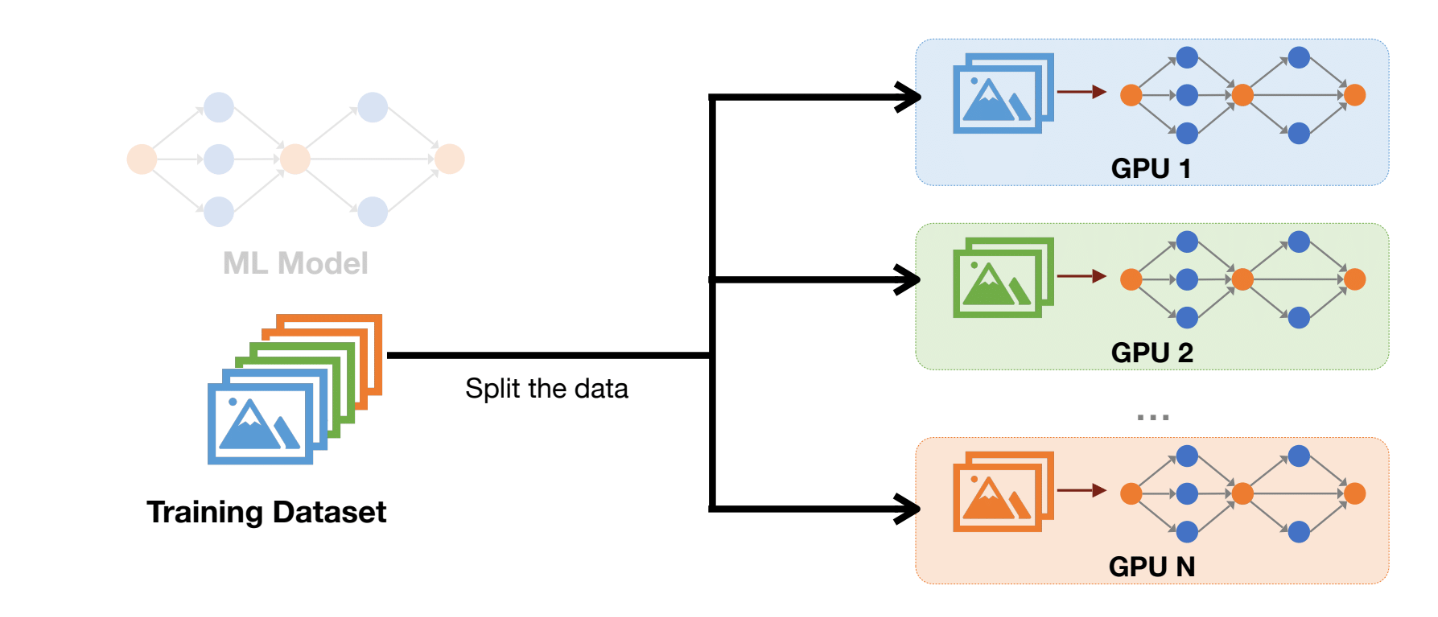

#### Can we do data parallelism without a central server ?
- Naive all reduce
  - Every node does a new reduce
  - Memory bandwidth is O(N) and time is O(N)
- Ring all reduce
  - Only communicate with your direct neighbor
  - Memory bandwith is O(1) and time is O(N)
- All reduce Parallel
  - Exchange info with neighor, then offset 2, offset 4 etc.
  - Info exchange in O(logN) steps. Memory bandwidth is O(1)


- Modern LLMs can't even fit inside a single GPU
  - 175B parameter with fp 16(2 bytes) needs 350 GB in memory

### Pipeline parallelism
- Split model into N GPUs.
  - Sounds complex

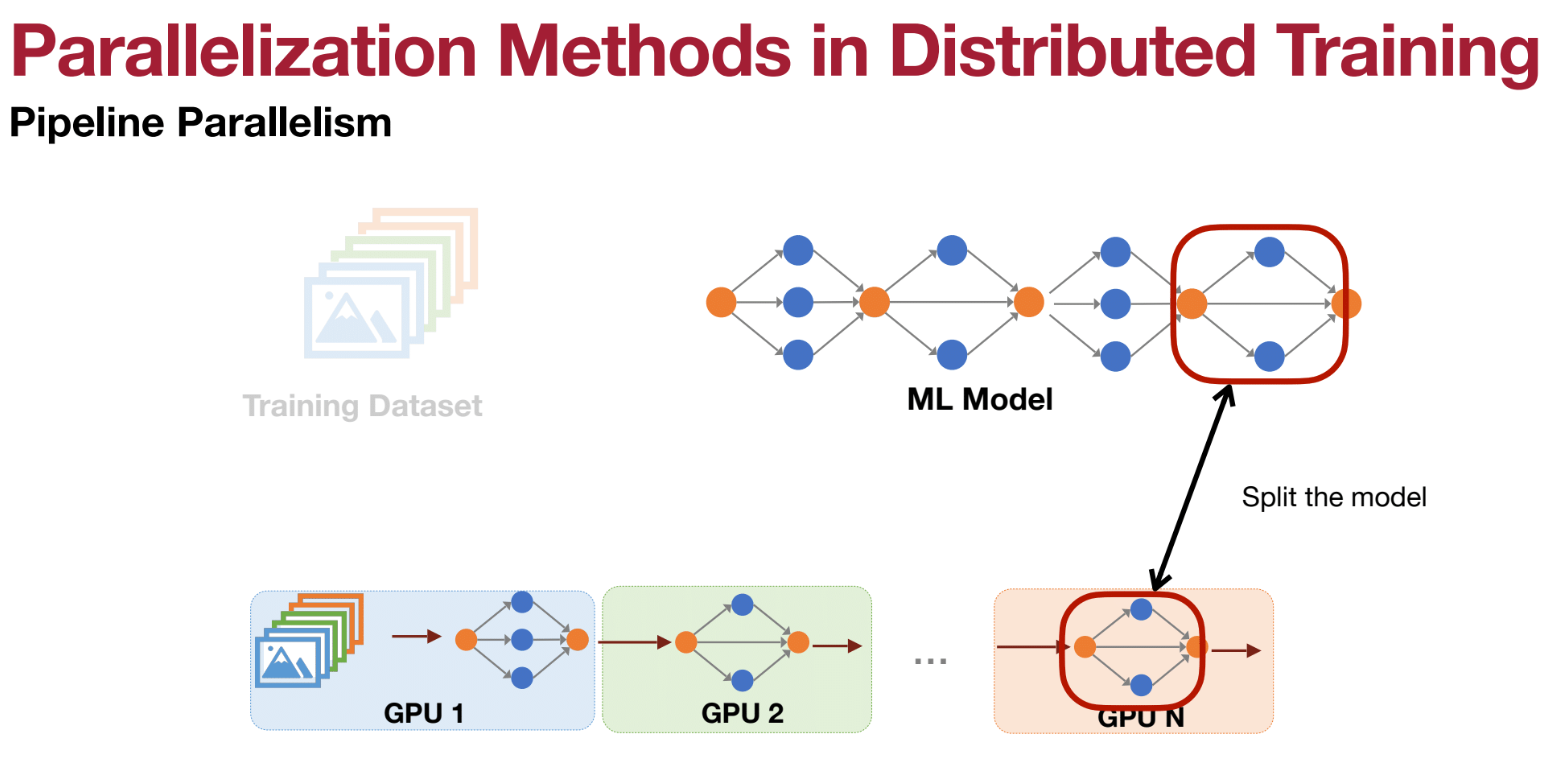

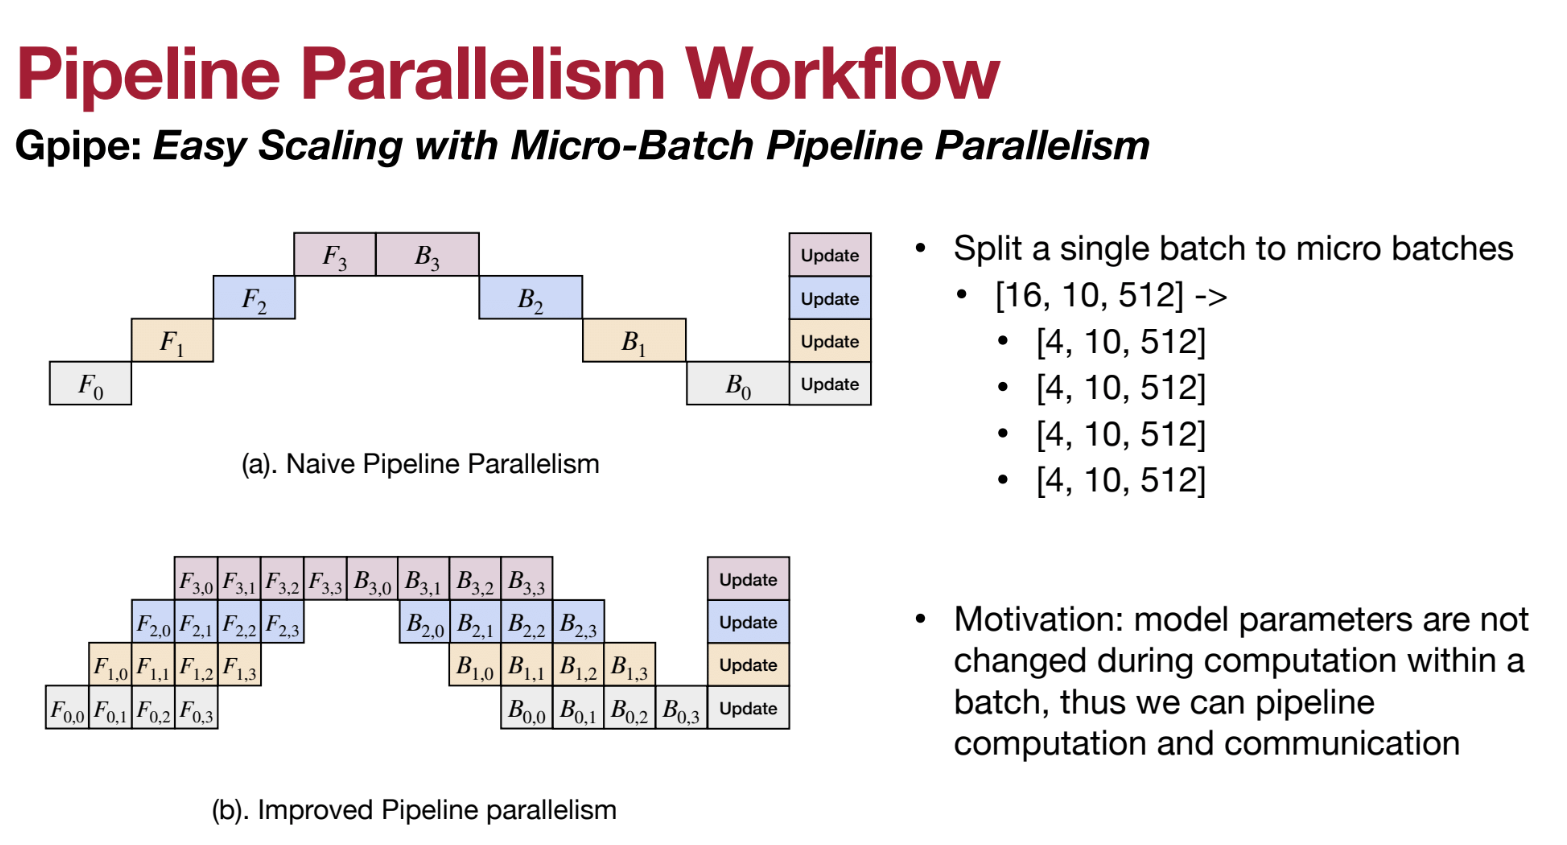

### Tensor parallalism
- Split the tensor

- Number of steps would be 100,000 / 1024 = 100. For batch size 1024 processing time is ~0.41 seconds, with the bottleneck being gpu transfer time. Time take to train one epoch with 256 batch size = 100 * 0.41 = 41 seconds. Time taken to train 100 epochs would be 4000 seconds or about 250 minutes.
- With gradient checkpointing and 4096 batchsize, 100,000 / 4096 = 24 steps are needed. Processing time is ~0.41 seconds. Time taken for one epoch is 24 * 0.41 = ~10 seconds. Time taken to train 100 epochs would be 1000 seconds. 4x reduction in training time. 

## Tiny imagenet experiments
- There are 100,000 images that need to train for 100 epochs
- I am going to run for one epoch and multiply by 100. 

- Time taken for one epoch = (N / B) * time per batch
    - 100000 / 256 * 0.57 = 222
    - 100000 / 1500 * 2 = 133
    - 100000 / 2500 * 3.5 = 140
    - 
- For 100 epochs, with checkpointing should be around ~6 hours and with checkpointing it should be around ~3.69 hours

| Name | batch_size | num_workers | gradient_checkpointing | data_parallel | distributed_data_parallel | Processing Time per batch | Estimated Time 1 epochs | Actual Time 1 epochs | Comments |
|---------|------------|-------------|--------------------------|-------------------|--------------------------------|--------------------------------|---------------|-------------|-----------|
| baseline | 512 | 2 | False | False | False | 0.57 | 222 |  | Standard training setup |
| gradient_checkpointing | 1500 | 2 | True | False | False | 2 | 133 |  | Trades computation for memory savings |
| data_parallel | 2500 | 2 | False | True | False | |  | 140 | Uses DataParallel for multi-GPU training |
| distributed_data_parallel | 1500 | 2 | False | False | True | |  | 86  | Uses DistributedDataParallel for better efficiency |


### nn.Parallel vs nn.DataParallel
- nn.Parallel uses multi threaded process to distribute data across GPUs. There is a central server which handles the coordination. This is inefficient because the python interpretter executes one thread at a time. So this offers limited parallelizing power. 
    - Scatter minibatch data across GPUs, replicate model from master to other GPUs, run forward pass on each gpu parallely, gather output on master gpu, compute loss, scatter loss, compute gradients on edge nodes, reduce gradients on master, update model parameters
    - Extra data copy, from disk to master GPU, then distributed across GPUs. 
    - Uneven GPU usage, loss calculation on master, forward, backward pass on other GPUs. 
- nn.DataParallel spins off seperate processes in different GPUs, no central server. DistributedSampler ensures non-overlapping data is fed to all systems. 
    - Has multiple processes, each gpu has identical copy of model, no need to copy model across GPUs
        - Spread data across gpus from disk, run forward pass, get loss, run backward pass, get gradients, perform gradient all reduce. Gradient communication is done parallel with gradient computation. No model sync is needed. 
        - Gradients of layer L is independent of gradients of layer L-1, thus once gradients of L is computed, GPU can begin transmission of layer L to other GPUs, and can move onto computing layer L-1. All GPUs wait together in the end. 
- Example
    - Gradient computation is 1 sec, communication is 0.5 seconds. 
    - If we have 10 layers, doing gradient computation first, communicating later is going to take 15 seconds. 
    - If we can interleave 9 communication with gradient computation, then it will take 9 + 1 + 0.5 = 10.5. The communication cost of 9 layers is now cut because of overlap. 

Without Pipelining:
```
Time   |  Computation          |  Communication
-------|----------------------|------------------
0-10   |  Compute all grads   |  -
10-15  |  -                   |  All-reduce all
15     |  Update parameters   |  -
```
Total time: 15 units

With Pipelining:
```
Time   |  Computation          |  Communication
-------|----------------------|------------------
0-1    |  Compute Layer10 grad|  -
1-2    |  Compute Layer9 grad |  All-reduce Layer10
2-3    |  Compute Layer8 grad |  All-reduce Layer9
3-4    |  Compute Layer7 grad |  All-reduce Layer8
4-5    |  Compute Layer6 grad |  All-reduce Layer7
5-6    |  Compute Layer5 grad |  All-reduce Layer6
6-7    |  Compute Layer4 grad |  All-reduce Layer5
7-8    |  Compute Layer3 grad |  All-reduce Layer4
8-9    |  Compute Layer2 grad |  All-reduce Layer3
9-10   |  Compute Layer1 grad |  All-reduce Layer2
10-10.5|  -                   |  All-reduce Layer1
10.5   |  Update parameters   |  -
```
Total time: 10.5 units
